In [23]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.errors import InvalidDicomError
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np

In [4]:
# Load the dataset
csv_path = '/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/data/Mammo/All_XWalk_Outcome_cleaned.csv'
data = pd.read_csv(csv_path, sep=',', quotechar='"', low_memory=False)

In [5]:
# Check data
print(data.head())

        patient_id               PatientName  PatientDOB OriginalID  \
0  20130102_0g0aud  Roberge^Annette^Patricia  1958-09-17    9093889   
1  20130102_1s02ke             Kim^Myung Soo  1949-12-26    2191507   
2  20130102_4gw29z          Cunnington^Donna  1939-05-18    1093886   
3  20130102_5fjuf1          Lo^Anita^Oi Fong  1951-09-13    2186762   
4  20130102_5ih7tj               Meng^Jinsoo  1952-10-08    2191501   

   StudyDate AccessionNumber  \
0   20130102    104MG1300015   
1   20130102    104MG1300048   
2   20130102    104MG1300018   
3   20130102    104MG1300058   
4   20130102    104MG1300019   

                                            FilePath      SheetName  \
0  Q:\BCWomen\BDenStorage\Screening\20130102\2013...  BCW-Screening   
1  Q:\BCWomen\BDenStorage\Screening\20130102\2013...  BCW-Screening   
2  Q:\BCWomen\BDenStorage\Screening\20130102\2013...  BCW-Screening   
3  Q:\BCWomen\BDenStorage\Screening\20130102\2013...  BCW-Screening   
4  Q:\BCWomen\BDenStorage

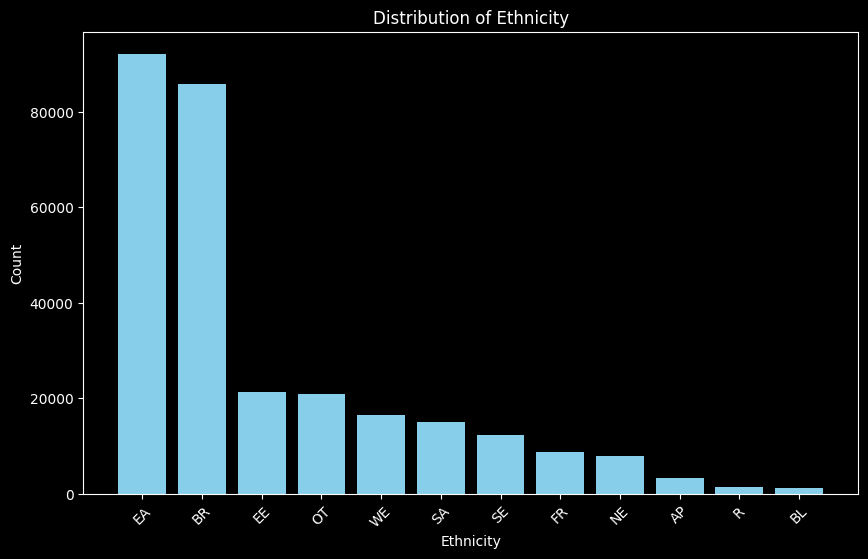

In [6]:
# Show the distribution of ethnicity
ethnicity_counts = data['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='skyblue')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Distribution of Ethnicity')
plt.xticks(rotation=45)
plt.show()

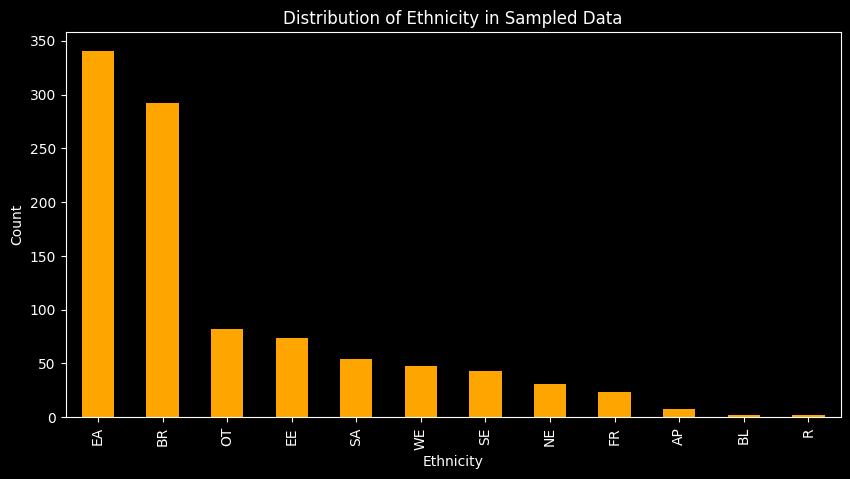

In [7]:
# Randomly select about 1000 images
data_sample = data.sample(n=1000, random_state=42)
# Verify sampled distribution
plt.figure(figsize=(10, 5))
data_sample['ethnicity'].value_counts().plot(kind='bar', color='orange')
plt.title('Distribution of Ethnicity in Sampled Data')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.show()

In [8]:
# Define the correct base path
correct_base_path = "/mnt/disk_share/AIRM"

# Replace 'Q:\\' with the correct base path and standardize separators
data['FilePath'] = data['FilePath'].str.replace(r"^Q:\\", correct_base_path + "/", regex=True)
data['FilePath'] = data['FilePath'].str.replace(r"\\\\|\\", "/", regex=True)  # Replace backslashes with forward slashes

# Debugging: Print sample paths to verify
print(data['FilePath'].head())

0    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
1    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
2    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
3    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
4    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
Name: FilePath, dtype: object


In [9]:
# Filter out rows with invalid or missing FilePath
data_sample = data.sample(n=1000, random_state=42)
data_sample = data_sample.dropna(subset=['FilePath'])  # Remove rows with NaN in FilePath
data_sample = data_sample[data_sample['FilePath'].apply(lambda x: isinstance(x, str))]  # Keep only string paths

valid_filepaths = []
labels = []

for _, row in data_sample.iterrows():
    folder_path = row['FilePath']
    if os.path.exists(folder_path):  # Check if folder exists
        dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]
        if dicom_files:  # Check if DICOM files are present
            valid_filepaths.append(os.path.join(folder_path, dicom_files[0]))
            labels.append(row['ethnicity'])

# Display count of valid files
print(f"Number of valid DICOM files: {len(valid_filepaths)}")

Number of valid DICOM files: 994


In [10]:
# Convert labels to numeric format
def encode_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(set(labels))}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels, label_mapping

encoded_labels, label_mapping = encode_labels(labels)

# Prepare dataset for training
train_paths, test_paths, train_labels, test_labels = train_test_split(
    valid_filepaths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
)

In [17]:
# Define example mapping
def map_example(filepath, label):
    try:
        dicom = dcmread(filepath.numpy().decode('utf-8'))
        if 'PixelData' not in dicom or dicom.pixel_array is None:
            raise ValueError("Invalid DICOM: Missing pixel data")
        image = dicom.pixel_array
        if len(image.shape) == 2:  # Grayscale image
            image = tf.expand_dims(image, axis=-1)  # Add channel dimension
        image = tf.image.resize(image, [224, 224])  # Resize to 224x224
        if image.shape[-1] == 1:  # Grayscale
            image = tf.image.grayscale_to_rgb(image)  # Convert to RGB
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        return image, label
    except (InvalidDicomError, ValueError) as e:
        print(f"Skipping file {filepath.numpy().decode('utf-8')}: {e}")
        return tf.zeros((224, 224, 3)), -1  # Return dummy image and invalid label

# Wrapper function for TensorFlow compatibility
def tf_map_example(filepath, label):
    image, label = tf.py_function(func=map_example, inp=[filepath, label], Tout=(tf.float32, tf.int32))
    image.set_shape((224, 224, 3))  # Explicitly set shape for TensorFlow graph
    label.set_shape([])  # Set shape for label as scalar
    return image, label

# Create datasets
def make_dataset(filepaths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(tf_map_example)  # Use the wrapper function
    dataset = dataset.filter(lambda x, y: y != -1)  # Filter out invalid entries
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare datasets
train_dataset = make_dataset(train_paths, train_labels)
test_dataset = make_dataset(test_paths, test_labels)

In [18]:
for image_batch, label_batch in train_dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


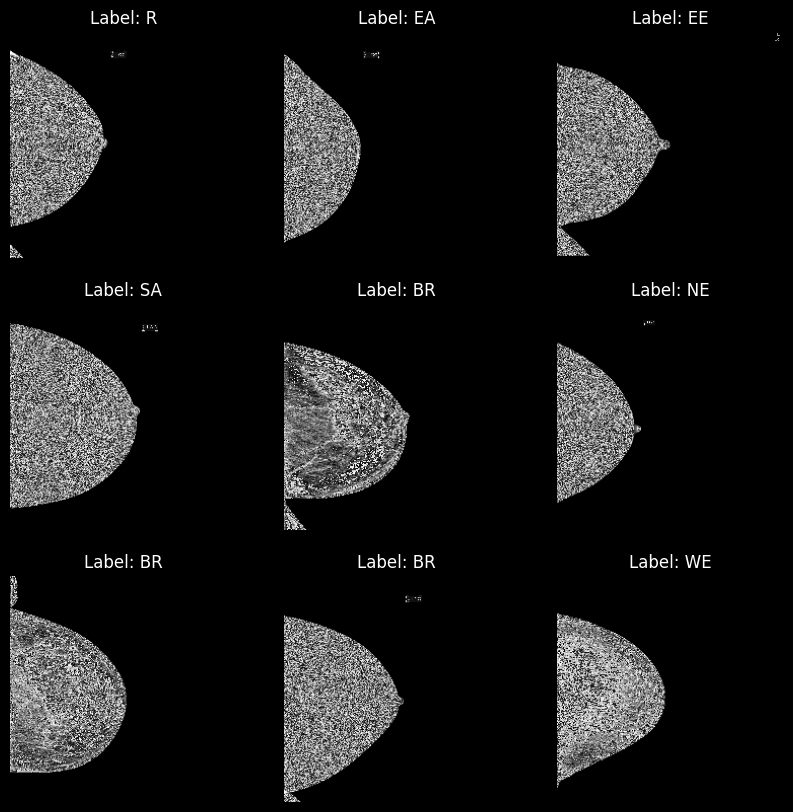

In [28]:
# Display sample images and their labels
for image_batch, label_batch in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(f"Label: {list(label_mapping.keys())[list(label_mapping.values()).index(label_batch[i].numpy())]}")
        plt.axis("off")
    plt.show()

In [19]:
# Build EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(label_mapping), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/30
      2/Unknown - 58s 23s/step - loss: 2.2133 - accuracy: 0.3281Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20131001/20131001_d9gi7z/20131001_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
      3/Unknown - 81s 23s/step - loss: 2.1043 - accuracy: 0.3438Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20170227/20130121_x5j84y/20170227_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20130819/20130819_2gacdu/20130819_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
      5/Unknown - 130s 24s/step - loss: 2.0602 - accuracy: 0.3500Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20151014/20130819_g43jih/20151014_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
      6/Unknown - 159s 25s/step - loss: 1.9723 - accuracy: 0.3906Skipping fi

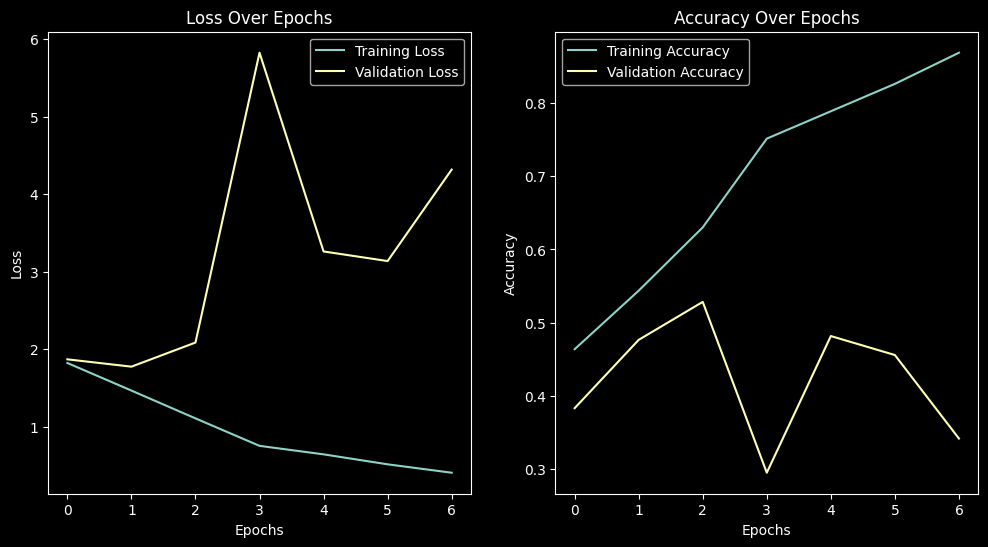

In [20]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20191202/20191202_64jx14/20191202_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
      3/Unknown - 216s 73s/stepSkipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20180409/20190409_usdvr3/20180409_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20140515/20200305_sn71sc/20140515_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
Skipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20150212/20130222_gmjdwf/20150212_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
      4/Unknown - 287s 73s/stepSkipping file /mnt/disk_share/AIRM/XRay505/BDenStorage/Screening/20191213/20220202_mprxfx/20191213_BC Cancer Screening/KOBC Cancer Screening.dcm: Invalid DICOM: Missing pixel data
      5/Unknown - 362s 73s/stepSkippin

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (12).

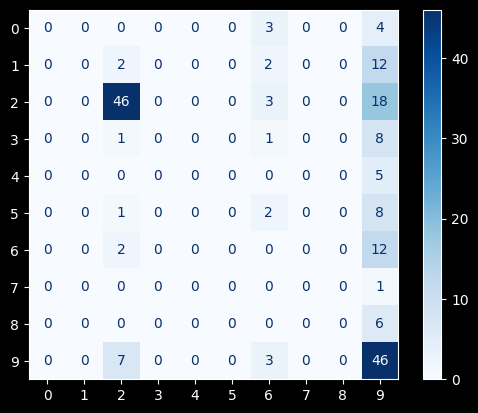

In [30]:
# Evaluate the model and compute metrics
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
display_labels = [key for key, value in sorted(label_mapping.items(), key=lambda item: item[1])]
ConfusionMatrixDisplay(conf_matrix, display_labels=display_labels).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=display_labels))
